# Emotion Recognition in Voice Recordings
##### Joseph Golubchik (209195353), Johann Thuillier (336104120), Shlomi Wenberger (203179403)

The aim of our project is to use logistic regression to classify a persons emotional state from a recording of him speaking.  

## Dataset
The dataset we used is “The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)”  
https://zenodo.org/record/1188976  

The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression. All conditions are available in three modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4), and Video-only (no sound). We used only the speach files and not the song files, and used only the audio files and not the videos.

Speech file contains 1440 files: 60 trials per actor x 24 actors = 1440. The labels for each file will be taken from the filenames: The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: Filename identifiers Modality (01 = full-AV, 02 = video-only, 03 = audio-only). Vocal channel (01 = speech, 02 = song). Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised). Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion. Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door"). Repetition (01 = 1st repetition, 02 = 2nd repetition). Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


## Dependencies

In [1]:
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import timeit

## First Attempt - Distinguishing Between Happy and Sad Recordings
At first we tried logistic regression with only two classes - happy and sad.
It couldn't do any better than guessing, with the best accuracy being 0.5 when it guessed all examples were sad.

In [2]:
# Loading the filenames from the folder with the audio files.
filenames = []
for file in os.listdir('audio'):
    if file[7] == '3' or file[7] == '4':
        filenames.append(file)

# Shuffling the filenames array.
random.shuffle(filenames)

# Spliting the dataset into train and test files,
# 70% train and 30% test.
num_train = int(len(filenames)*0.7)
num_test = len(filenames) - num_train

print("Number of files =",len(filenames),",Number of actors =",int(len(filenames)/16))
print("Number of train examples =",num_train,",Number of test examples =",num_test)

Number of files = 384 ,Number of actors = 24
Number of train examples = 268 ,Number of test examples = 116


In [3]:
data_x_train = []
data_x_test = []
data_y_train = []
data_y_test = []

start_time = timeit.default_timer()

# For each of the training examples,
# extract from each file its Mel-frequency cepstral coefficients (MFCCs)
# and append the mfccs to the array that stores the features of each train file - data_x_train.
# look at the filename and create a label for the example,
# Where the 8'th character is '3' if the file is a sad recording and '4' if it's a happy recording.
for filename in filenames[:num_train]:
    if filename[7] == '3':
        data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
        sampling_rate = np.array(sampling_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
        data_x_train.append(mfccs)
        data_y_train.append(1)
    elif filename[7] == '4':
        data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
        sampling_rate = np.array(sampling_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
        data_x_train.append(mfccs)
        data_y_train.append(0)

# Do the same for the testing examples.
for filename in filenames[num_train:]:
    if filename[7] == '3':
        data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
        sampling_rate = np.array(sampling_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
        data_x_test.append(mfccs)
        data_y_test.append(1)
    elif filename[7] == '4':
        data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
        sampling_rate = np.array(sampling_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
        data_x_test.append(mfccs)
        data_y_test.append(0)
    
stop_time = timeit.default_timer()
print('Loading time:', stop_time - start_time, "Seconds")  

Loading time: 50.501757231971254 Seconds


In [4]:
# Tensorflow requires the y array that it gets to be of the shape (none, 1)
# This converts our data_y arrays from the shape (none, ) to the required shape (none, 1)
# ex: [0, 1, 1, 1, 0] => [[0], [1], [1], [1], [0]]
data_y_train_correct = []
data_y_test_correct = []

for val in data_y_train:
    val_arr = []
    val_arr.append(val)
    data_y_train_correct.append(val_arr)
    
for val in data_y_test:
    val_arr = []
    val_arr.append(val)
    data_y_test_correct.append(val_arr)

In [57]:
# We create a new array that will contain tuples where the first element is the features of the example,
# and the second element is the label of the example.
# This is neccesary so we can shuffle the order of the examples around after each training epoch.
data_xy_train = []
for i in range(len(data_x_train)):
    data_xy_train.append( (data_x_train[i], data_y_train_correct[i]) )
    
data_xy_test = []
for i in range(len(data_x_test)):
    data_xy_test.append( (data_x_test[i], data_y_test_correct[i]) )

In [58]:
# Function to extract only the features from data_xy
def getXvalues(data_xy):
    x_values = []
    for data in data_xy:
        x_values.append(data[0])
    return x_values

# Function to extract only the labels from data_xy
def getYvalues(data_xy):
    y_values = []
    for data in data_xy:
        y_values.append(data[1])
    return y_values

# Sigmoid function
def logistic_fun(z):
    return 1/(1.0 + np.exp(-z))

In [128]:
features = len(data_xy_train[0][0])
eps = 1e-12

x = tf.placeholder(tf.float32, [None, features])
y_ = tf.placeholder(tf.float32, [None, 1])
W = tf.Variable(tf.zeros([features,1]))
b = tf.Variable(tf.zeros([1]))
y = tf.nn.sigmoid(tf.matmul(x,W) + b)

loss1 = -(y_ * tf.log(y + eps) + (1 - y_) * tf.log(1 - y + eps))
loss = tf.reduce_mean(loss1)
update = tf.train.GradientDescentOptimizer(0.00001).minimize(loss)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

loss_history_train = []
loss_history_test = []
accuracy_history = []

start_time = timeit.default_timer()

for i in range(0,1000):
    sess.run(update, feed_dict = {x:getXvalues(data_xy_train), y_:getYvalues(data_xy_train)}) #BGD
    loss_history_train.append(np.mean(sess.run(loss1, feed_dict = {x:getXvalues(data_xy_train), y_:getYvalues(data_xy_train)})))
    random.shuffle(data_xy_train)
    
    if i%1 == 0:
        tp, tn, fp, fn = 0,0,0,0
        for i in range(len(data_x_test)):
            pred = logistic_fun(np.matmul(getXvalues(data_xy_test)[i],sess.run(W)) + sess.run(b))
            loss_history_test.append(np.mean(sess.run(loss1, feed_dict = {x:getXvalues(data_xy_test), y_:getYvalues(data_xy_test)})))
            if data_y_test[i] == 0 and pred < 0.5:
                tn += 1
            elif data_y_test[i] == 0 and pred > 0.5:
                fn += 1
            if data_y_test[i] == 1 and pred > 0.5:
                tp += 1
            elif data_y_test[i] == 1 and pred < 0.5:
                fp += 1
        accuracy_history.append((tp+tn)/(tp+tn+fp+fn))

stop_time = timeit.default_timer()
print('runtime: ', stop_time - start_time)  

runtime:  87.97681283821612


In [133]:
tp, tn, fp, fn = 0,0,0,0
for i in range(len(data_x_test)):
    pred = logistic_fun(np.matmul(getXvalues(data_xy_test)[i],sess.run(W)) + sess.run(b))
    if data_y_test[i] == 0 and pred < 0.5:
        tn += 1
    elif data_y_test[i] == 0 and pred > 0.5:
        fn += 1
    if data_y_test[i] == 1 and pred > 0.5:
        tp += 1
    elif data_y_test[i] == 1 and pred < 0.5:
        fp += 1
#     print("pred:",pred,"=",np.round(pred),"true:",data_y_test[i])
print("tp:",tp,",tn",tn,",fp:",fp,",fn:",fn)
print("accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("recall:",(tp)/(tp+fn))
print("precision:",(tp)/(tp+fp))

tp: 11 ,tn 8 ,fp: 13 ,fn: 16
accuracy: 0.3958333333333333
recall: 0.4074074074074074
precision: 0.4583333333333333


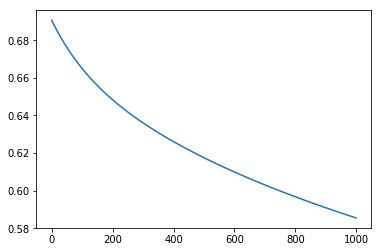

In [134]:
plt.plot(loss_history_train)

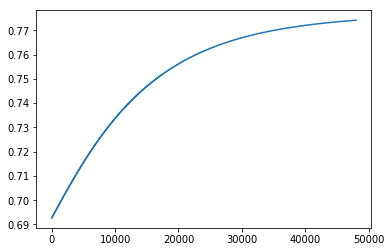

In [135]:
plt.plot(loss_history_test)

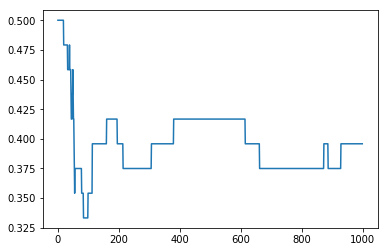

In [136]:
plt.plot(accuracy_history)


## Second Attempt - Classifying an example as belonging to one of eight different emotions.
The best accuracy we achieved is 0.35.
We think that this problem is probably too complex for logistic regression, and a more advanced system is required to achieve decent results.


In [5]:
# Loading the filenames from the folder with the audio files.
filenames = []
for file in os.listdir('audio'):
    filenames.append(file)

# Shuffling the filenames array.
random.shuffle(filenames)

# Spliting the dataset into train and test files,
# 70% train and 30% test.
num_train = int(len(filenames)*0.7)
num_test = len(filenames) - num_train

print("Number of files =",len(filenames),",Number of actors =",int(len(filenames)/60))
print("Number of train examples =",num_train,",Number of test examples =",num_test)

Number of files = 384 ,Number of actors = 6
Number of train examples = 268 ,Number of test examples = 116


In [6]:
data_x_train = []
data_x_test = []
data_y_train = []
data_y_test = []

start_time = timeit.default_timer()

# For each of the training examples,
# extract from each file its Mel-frequency cepstral coefficients (MFCCs)
# and append the mfccs to the array that stores the features of each train file - data_x_train.
# look at the filename and create a label for the example,
# Where the 8'th character determines the label.
# Ex: filename[7] == 3 => label: [0,0,1,0,0,0,0,0]
for filename in filenames[:num_train]:
    data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
    sampling_rate = np.array(sampling_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
    data_x_train.append(mfccs)
    label = np.zeros(8)
    label[int(filename[7])-1] = 1
    data_y_train.append(label)

# Do the same for the testing examples.
for filename in filenames[num_train:]:
    data, sampling_rate = librosa.load("audio/" + filename, sr=22050*2, res_type='kaiser_fast', duration=2.5, offset=0.5)
    sampling_rate = np.array(sampling_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=13), axis=0)
    data_x_test.append(mfccs)
    label = np.zeros(8)
    label[int(filename[7])-1] = 1
    data_y_test.append(label)
    
stop_time = timeit.default_timer()
print('Loading time:', stop_time - start_time, "Seconds")  

Loading time: 44.651644465489 Seconds


In [7]:
# Tensorflow requires the y array that it gets to be of the shape (none, 1)
# This converts our data_y arrays from the shape (none, ) to the required shape (none, 1)
# ex: [0, 1, 1, 1, 0] => [[0], [1], [1], [1], [0]]
data_y_train_correct = []
data_y_test_correct = []

for val in data_y_train:
    val_arr = []
    val_arr.append(val)
    data_y_train_correct.append(val_arr)
    
for val in data_y_test:
    val_arr = []
    val_arr.append(val)
    data_y_test_correct.append(val_arr)

In [8]:
# We create a new array that will contain tuples where the first element is the features of the example,
# and the second element is the label of the example.
# This is neccesary so we can shuffle the order of the examples around after each training epoch.
data_xy_train = []
for i in range(len(data_x_train)):
    data_xy_train.append( (data_x_train[i], data_y_train_correct[i]) )
    
data_xy_test = []
for i in range(len(data_x_test)):
    data_xy_test.append( (data_x_test[i], data_y_test_correct[i]) )

In [171]:
features = len(data_xy_train[0][0])
x = tf.placeholder(tf.float32, [None, features])
y_ = tf.placeholder(tf.float32, [None, 8])
W = tf.Variable(tf.zeros([features, 8]))
b = tf.Variable(tf.zeros([8]))
y = tf.nn.softmax(tf.matmul(x, W) + b)

cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1])+0.1*tf.nn.l2_loss(W))
train_step = tf.train.GradientDescentOptimizer(0.00005).minimize(cross_entropy)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

start_time = timeit.default_timer()

for i in range(2100):
    sess.run(train_step, feed_dict={x:getXvalues(data_xy_train), y_:data_y_train})
#     random.shuffle(data_xy_train)
    
stop_time = timeit.default_timer()
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print("Accuracy:", sess.run(accuracy, feed_dict={x:getXvalues(data_xy_test), y_:data_y_test}))
print('runtime: ', stop_time - start_time)  

Accuracy: 0.35
runtime:  6.888490701001501


In [19]:
np.shape(np.expand_dims(data_xy_train, axis=2))
np.expand_dims(data_xy_train, axis=2)[0]

array([[array([-54.57418211, -55.88386158, -58.91245306, -55.59317068,
       -55.94652149, -59.77825533, -58.92754627, -58.31220486,
       -57.07825355, -58.85695291, -60.24484194, -59.95802523,
       -59.28588421, -58.81425321, -58.48950189, -58.25587231,
       -58.84145347, -63.76618257, -63.57184286, -61.41523766,
       -61.83906473, -61.31746154, -62.9408323 , -65.13322554,
       -62.72210598, -63.08306093, -62.1183356 , -65.14052877,
       -64.98476522, -60.65427265, -60.08570362, -59.20849321,
       -56.85042882, -52.11421912, -51.97432432, -56.29773341,
       -55.59772861, -52.72543714, -53.47129785, -49.64927173,
       -47.19264257, -46.08680402, -32.75087477, -24.03799021,
       -22.78303756, -22.74279227, -22.51618013, -24.07140508,
       -24.17270171, -23.46917633, -24.98460545, -23.8995425 ,
       -23.62830335, -24.94383577, -24.41311764, -24.29987305,
       -25.13310239, -25.82299357, -25.37949049, -25.86577318,
       -27.57892199, -28.3117006 , -27.40038966

In [ ]:
features = len(data_xy_train[0][0])
x = tf.placeholder(tf.float32, [None, features])
y_ = tf.placeholder(tf.float32, [None, 8])

W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32]))
x_image = tf.reshape(x, [-1,216,216,1]) #if we had RGB, we would have 3 channels
h_conv1 = tf.nn.relu(tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64]))
h_conv2 = tf.nn.relu(tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME') + b_conv2)
h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
W_fc1 = tf.Variable(tf.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024]))
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
W_fc2 = tf.Variable(tf.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10]))
y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [ ]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy) #uses moving averages momentum

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())

for i in range(20000):

batch = mnist.train.next_batch(50)

if i%100 == 0:

train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})

print("step %d, training accuracy %g"%(i, train_accuracy))

train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels,
keep_prob: 1.0}))